In [1]:
import matplotlib as mpl
import pylab as pl

# params = {'axes.spines.right': False,
#           'axes.spines.top': False,
#           'legend.fontsize': 12,
#           'axes.labelsize': 12,
#           'axes.titlesize': 12,
#           'xtick.labelsize': 12,
#           'ytick.labelsize': 12,
#           'pdf.fonttype': 42,
#           'ps.fonttype': 42}
# mpl.rcParams.update(params)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl
import seaborn as sns

import nems.db as nd
from nems_lbhb.baphy_experiment import BAPHYExperiment
from nems.utils import smooth
from nems_lbhb import plots as nplt
from nems.xform_helper import load_model_xform
from scipy.stats import ranksums

# Mateo source
from src.root_path import config_path
from src.visualization.fancy_plots import savefig

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2021-11-01 143948.log
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:66: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:76: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/SettingXML.py:81: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  {K: SubEl.get(K) for K in SubEl.keys() if K is not 'name'}
/auto/users/mateo/nems_db/nems_lbhb/plots.py:757: SyntaxWarning: "is" with a literal. Did you mean "=="?
  while tf is 0:
/auto/users/mateo/NEMS/nems/fitters/mappers.py:17: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if which is 'lower':
/auto/users/mateo/NEMS/nems/fitters/mappers.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif which is 'upper':
/auto/u

In [2]:
def get_rec(parmfile, cellid, rasterfs=1000, pupil=False):
    e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
    
    #t = cellid.split("-")
    #e.channels_to_load = [int(t[1])]
    #e.units_to_load = [int(t[2])]

    options={'resp': 1, 'rasterfs': rasterfs, 'pupil': pupil}
    
    rec = e.get_recording(**options)
    return rec

In [3]:
waveform_labels = pd.read_csv(pl.Path('/auto/users/mateo/nems_db/nems_lbhb/projects/phototag/phototag_waveform_labels.csv'), index_col=0)


# PSTH analysis

Pick a run class

In [4]:
runclass='TOR'
rasterfs=100

runclass='CPN'
rasterfs=500

# runclass='FTC'
#rasterfs=500

sql="select sCellFile.*,gSingleCell.siteid,gSingleCell.phototag from gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid" +\
   " INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid" +\
   f" WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']
print(len(d))
d.groupby('phototag').count()['cellid']

363


phototag
a     38
n    134
s    191
Name: cellid, dtype: int64

In [5]:
d['parmfile'].unique()

array(['/auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC013/TNC013a09_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC015/TNC015a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC017/TNC017a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC016/TNC016a11_p_CPN.m',
       '/auto/data/daq/Teonancatl/TNC018/TNC018a12_p_CPN.m'], dtype=object)

In [6]:
parmfile="/auto/data/daq/Teonancatl/TNC014/TNC014a09_p_CPN.m"
cellid="TNC014a-01-2"

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs,'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_e41af539df4bf7394fb7a19cee70b2d6c1299f49.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Load all A cells (sort of slow)

In [7]:
psth_a=[]
error_cellid=[]
for i, r in d.loc[d.phototag=='a'].iterrows():
    try:
        rec = get_rec(r.parmfile, r.cellid, rasterfs=rasterfs)
        rec['resp']=rec['resp'].rasterize()
        r=rec['resp'].extract_epoch('REFERENCE')
        psth_a.append(smooth(r.mean(axis=0)[0,:],5))
    except:
        error_cellid.append(r.cellid)


[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_963af78fd72e133caf2da6e7d1fb1c827f2cfa52.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_93ba346b3536e077ccf702cc01af1246a49c940f.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC013a/TNC013a_768a45d9c847cbaf8efe5db41c0068c96162c069.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC013a/TNC013a_81f4cd3833bfd21ea929a80595ea51b1d0b1d9de.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC013a/TNC013a_7d6b1ef70a38d890f5cd1675f0fcd59a0069bdad.tgz
[n

Load all S cells (slower)

In [8]:
psth_s=[]
for i, r in d.loc[d.phototag=='s'].iterrows():
    try:
        rec = get_rec(r.parmfile, r.cellid, rasterfs=rasterfs)
        rec['resp']=rec['resp'].rasterize()
        r=rec['resp'].extract_epoch('REFERENCE')
        psth_s.append(smooth(r.mean(axis=0)[0,:],5))
    except:
        error_cellid.append(r.cellid)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_2e775eabd6a87222656b2d942936daa5d4592787.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_d5661213365b1d28de0cd5e725a2258853893eb2.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_ee071e452d024ee39abefd0e6b45f93b65cd5e57.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_d92753c78813654b920df6e48c55dd965a9f5d6e.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found
[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC014a/TNC014a_07fd0d02cbfc3783e7b4a277ea7dd3f30d2e495b.tgz
[n

In [9]:
print('error cellids:', error_cellid)

error cellids: []


In [10]:
plt.style.use(['default', config_path / 'presentation.mplstyle'])


140.0 131.0


Text(0.5, 0, 'N units')

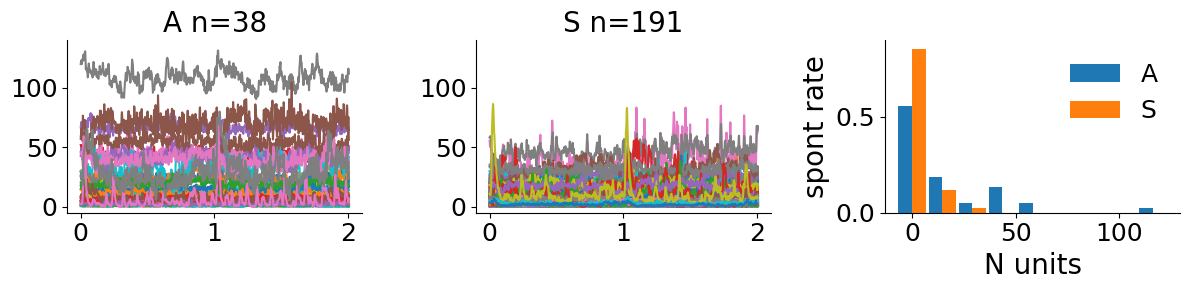

In [11]:
f,ax = plt.subplots(1,3,figsize=(12,3))

re=np.stack(psth_a) * rasterfs
ri=np.stack(psth_s) * rasterfs

ymax=np.ceil(np.max([re.max(), ri.max()])/10)*10
y0max=np.ceil(np.max([re[:,:50].max(), ri[:,:50].max()]))
print(ymax, y0max)

tt=np.arange(re.shape[1])/rasterfs
ax[0].plot(tt,re.T);
ax[0].set_title(f'A n={re.shape[0]}')
ax[0].set_ylim([-5, ymax])

ax[1].plot(tt,ri.T)
ax[1].set_title(f'S n={ri.shape[0]}');
ax[1].set_ylim([-5, ymax])

bins=np.linspace(0,y0max,10)
n0,b0 = np.histogram(re[:,:50].mean(axis=1), bins=bins)
n1,b1 = np.histogram(ri[:,:50].mean(axis=1), bins=bins)
n0= n0/n0.sum()
n1=n1/n1.sum()
w=(b0[1]-b0[0])/2.2
ax[2].bar(b0[:-1]-w/2,n0,width=w,label='A');
ax[2].bar(b0[:-1]+w/2,n1,width=w,label='S');
ax[2].legend(frameon=False);
ax[2].set_ylabel('spont rate')
ax[2].set_xlabel('N units')
#f.suptitle(runclass)

## formated for poster

In [12]:
def plot_signif(data=None, ax=None, yoffset=0, insigif=True, **kwargs):

    if data is not None:
        left_vals  = data.loc[data[kwargs['x']] == kwargs['order'][0], kwargs['y']].values
        right_vals  = data.loc[data[kwargs['x']] == kwargs['order'][1], kwargs['y']].values
    else:
        x = np.asarray(kwargs['x'])
        xu = np.unique(x)
        assert xu.size == 2
        y = np.asarray(kwargs['y'])
        left_vals = y[x == xu[0]]
        right_vals = y[x == xu[1]]

    stat, pval = ranksums(left_vals, right_vals)
    if insigif == False and pval > 0.05:
        return

    if ax == None:
        ax = plt.gca()

    # defines lines
    y_top, y_bottom = ax.get_ylim()

    line_y_pos = y_bottom + (y_top - y_bottom) * 0.22 + yoffset
    tick_y_pos = line_y_pos + (y_top - y_bottom) * 0.01

    if data is not None:
        line_x = [0, 0, 1, 1]
    else:
        line_x = [xu[0], xu[0], xu[1], xu[1]]

    line_y = [tick_y_pos, line_y_pos, line_y_pos, tick_y_pos]

    # defines  text position
    ypos = line_y_pos - (y_top - y_bottom) * 0.02
    if data is not None:
        xpos = 0.5
    else:
        xpos = (xu[0] + xu[1])/2


    ax.plot(line_x, line_y, linewidth=2, color='black')
    ax.text(xpos, ypos, f'p={pval:.3f}', ha='center')
    return ax

/auto/users/mateo/miniconda3/envs/context_probe_analysis2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


n supp=191, n act=38
firing_rate_sup191_act38
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/firing_rate_sup191_act38.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/firing_rate_sup191_act38.svg


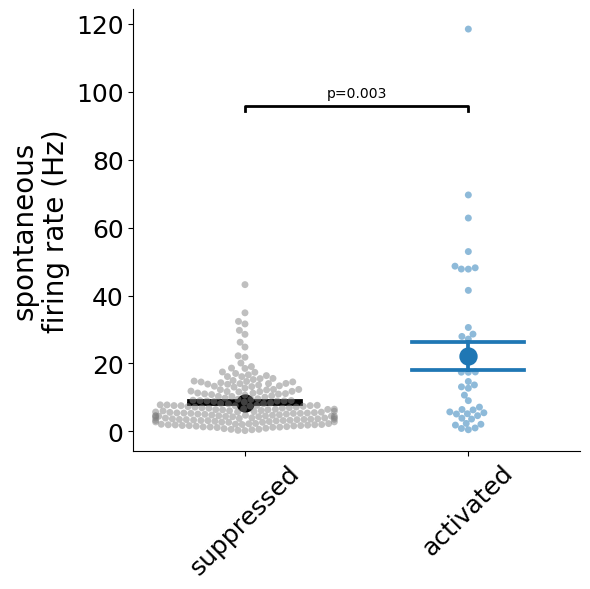

In [13]:
# fig, ax = plt.subplots()
adf = pd.DataFrame()
adf['spont_rate'] = re[:, :50].mean(axis=1)
adf['phototag'] = 'a'

sdf = pd.DataFrame()
sdf['spont_rate'] = ri[:, :50].mean(axis=1)
sdf['phototag'] = 's'

pldf = pd.concat([adf, sdf])

fig, ax = plt.subplots(figsize=(6,6))
_ = sns.swarmplot(data=pldf, x='phototag', y='spont_rate', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['gray', 'C0'], alpha=0.5, ax=ax)
_ = sns.pointplot(data=pldf, x='phototag', y='spont_rate', order=['s', 'a'],
                  hue='phototag', hue_order=['s', 'a'], palette=['black', 'C0'],
                  capsize=0.5, scale=1.5, ci=68, ax=ax)
_ = plot_signif(data=pldf, x='phototag', y='spont_rate', order=['s', 'a'], ax=ax)
print(f'n supp={ri.shape[0]}, n act={re.shape[0]}')
_ = ax.get_legend().remove()
_ = ax.set_xticklabels(['suppressed','activated'], rotation=45, ha='center')
_ = ax.set_ylabel('spontaneous\nfiring rate (Hz)')
_ = ax.set_xlabel('')
title = f'firing_rate_sup{ri.shape[0]}_act{re.shape[0]}'
print(title)
savefig(fig, 'SFN_poster', title, type='png')
savefig(fig, 'SFN_poster', title, type='svg')


# resp vs. pupil examples

In [14]:
# other S cells. potential examples
cellid_S="TNC016a-42-1"
cellid_S="TNC016a-45-1"
cellid_S="TNC016a-38-2"

cellid_S="TNC016a-30-1"
cellid_A="TNC016a-60-1"

runclass="CPN"
rasterfs=10  # or whatever rate you want

### EXAMPLE A CELL

In [15]:
cellid=cellid_A

df = nd.get_cell_files(cellid=cellid, runclass=runclass)
parmfile=df.loc[0,'stimpath']+df.loc[0,'stimfile']

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs, 'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_47475e422d2041b868682c8fa7200c5ffd7c0fff.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Text(0.5, 0, 'Experiment time (s)')

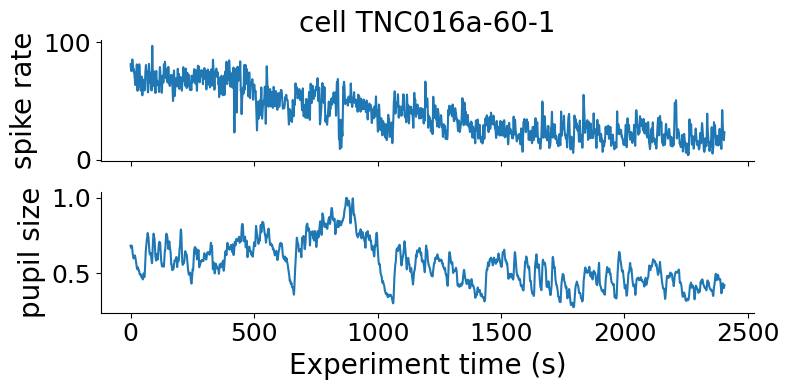

In [16]:
r=rec['resp'].rasterize().extract_epoch('REFERENCE')
resp=smooth(r.flatten(),50) * rasterfs
a_resp = resp

p=rec['pupil'].extract_epoch('REFERENCE')
pup = smooth(rec['pupil'].extract_epoch('REFERENCE').flatten(),50)
pup = pup / pup.max()

tt=np.arange(len(resp))/rasterfs

f,ax = plt.subplots(2,1,figsize=(8,4), sharex=True)
ax[0].plot(tt,resp)
ax[1].plot(tt,pup)
ax[0].set_title(f"cell {cellid}")
ax[0].set_ylabel("spike rate")
ax[1].set_ylabel("pupil size")
ax[1].set_xlabel("Experiment time (s)")

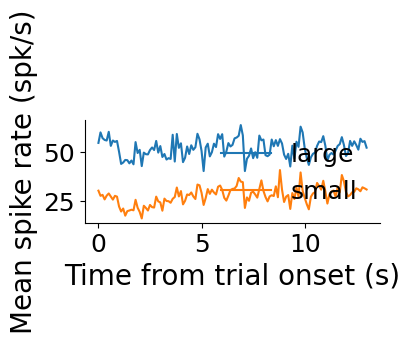

In [17]:
r=rec['resp'].rasterize().extract_epoch('TRIAL')
p=rec['pupil'].extract_epoch('TRIAL')
p=p.mean(axis=2)[:,0]
p_hi = p>np.median(p)
p_lo = p<=np.median(p)

psth_hi=r[p_hi,0,:].mean(axis=0) * rasterfs
a_hi_ref = psth_hi
psth_lo=r[p_lo,0,:].mean(axis=0) * rasterfs
a_lo_ref = psth_lo
tt=np.arange(len(psth_hi))/rasterfs
ref_time = tt

f,ax = plt.subplots(1,1,figsize=(4,2), sharex=True)
ax.plot(tt,psth_hi,label='large')
ax.plot(tt,psth_lo,label='small')
ax.legend(frameon=False)
ax.set_xlabel("Time from trial onset (s)")
ax.set_ylabel("Mean spike rate (spk/s)");

### EXAMPLE S CELL

In [18]:
cellid=cellid_S

df = nd.get_cell_files(cellid=cellid, runclass=runclass)
parmfile=df.loc[0,'stimpath']+df.loc[0,'stimfile']

e = BAPHYExperiment(parmfile=parmfile, cellid=cellid)
options={'resp': 1, 'rasterfs': rasterfs, 'pupil': True}    
rec = e.get_recording(**options)

[nems_lbhb.baphy_experiment INFO] Cached recording: /auto/data/nems_db/recordings/Teonancatl/TNC016a/TNC016a_67bd14ac8bc62dbda913a4ab3ac88820d2570a2d.tgz
[nems_lbhb.baphy_experiment INFO] Cached recording found


Text(0.5, 0, 'Experiment time (s)')

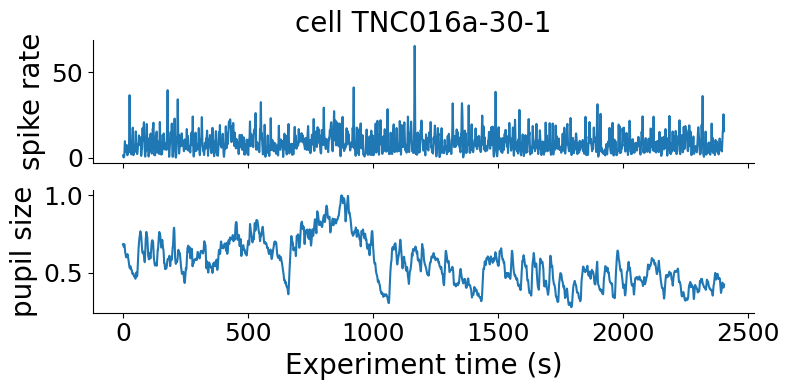

In [19]:
r=rec['resp'].rasterize().extract_epoch('REFERENCE')
resp=smooth(r.flatten(),50) * rasterfs
s_resp = resp

p=rec['pupil'].extract_epoch('REFERENCE')
pup = smooth(rec['pupil'].extract_epoch('REFERENCE').flatten(),50)
pup = pup / pup.max()
norm_pup = pup

tt=np.arange(len(resp))/rasterfs
rec_time = tt


f,ax = plt.subplots(2,1,figsize=(8,4), sharex=True)
ax[0].plot(tt,resp)
ax[1].plot(tt,pup)
ax[0].set_title(f"cell {cellid}")
ax[0].set_ylabel("spike rate")
ax[1].set_ylabel("pupil size")
ax[1].set_xlabel("Experiment time (s)")

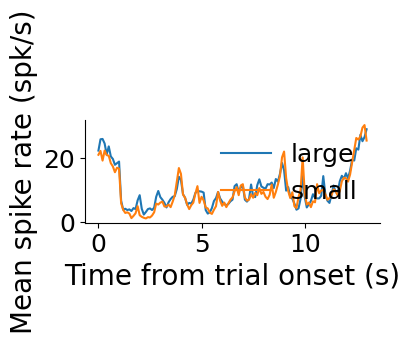

In [20]:
r=rec['resp'].rasterize().extract_epoch('TRIAL')
p=rec['pupil'].extract_epoch('TRIAL')
p=p.mean(axis=2)[:,0]
pup_threshold = np.median(p / np.max(p))
p_hi = p>np.median(p)
p_lo = p<=np.median(p)

psth_hi=r[p_hi,0,:].mean(axis=0) * rasterfs
s_hi_ref = psth_hi
psth_lo=r[p_lo,0,:].mean(axis=0) * rasterfs
s_lo_ref = psth_lo
tt=np.arange(len(psth_hi))/rasterfs
ref_time = tt

f,ax = plt.subplots(1,1,figsize=(4,2), sharex=True)
ax.plot(tt,psth_hi,label='large')
ax.plot(tt,psth_lo,label='small')
ax.legend(frameon=False)
ax.set_xlabel("Time from trial onset (s)")
ax.set_ylabel("Mean spike rate (spk/s)");


# poster ready

pupil example cells
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/pupil example cells.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/pupil example cells.svg


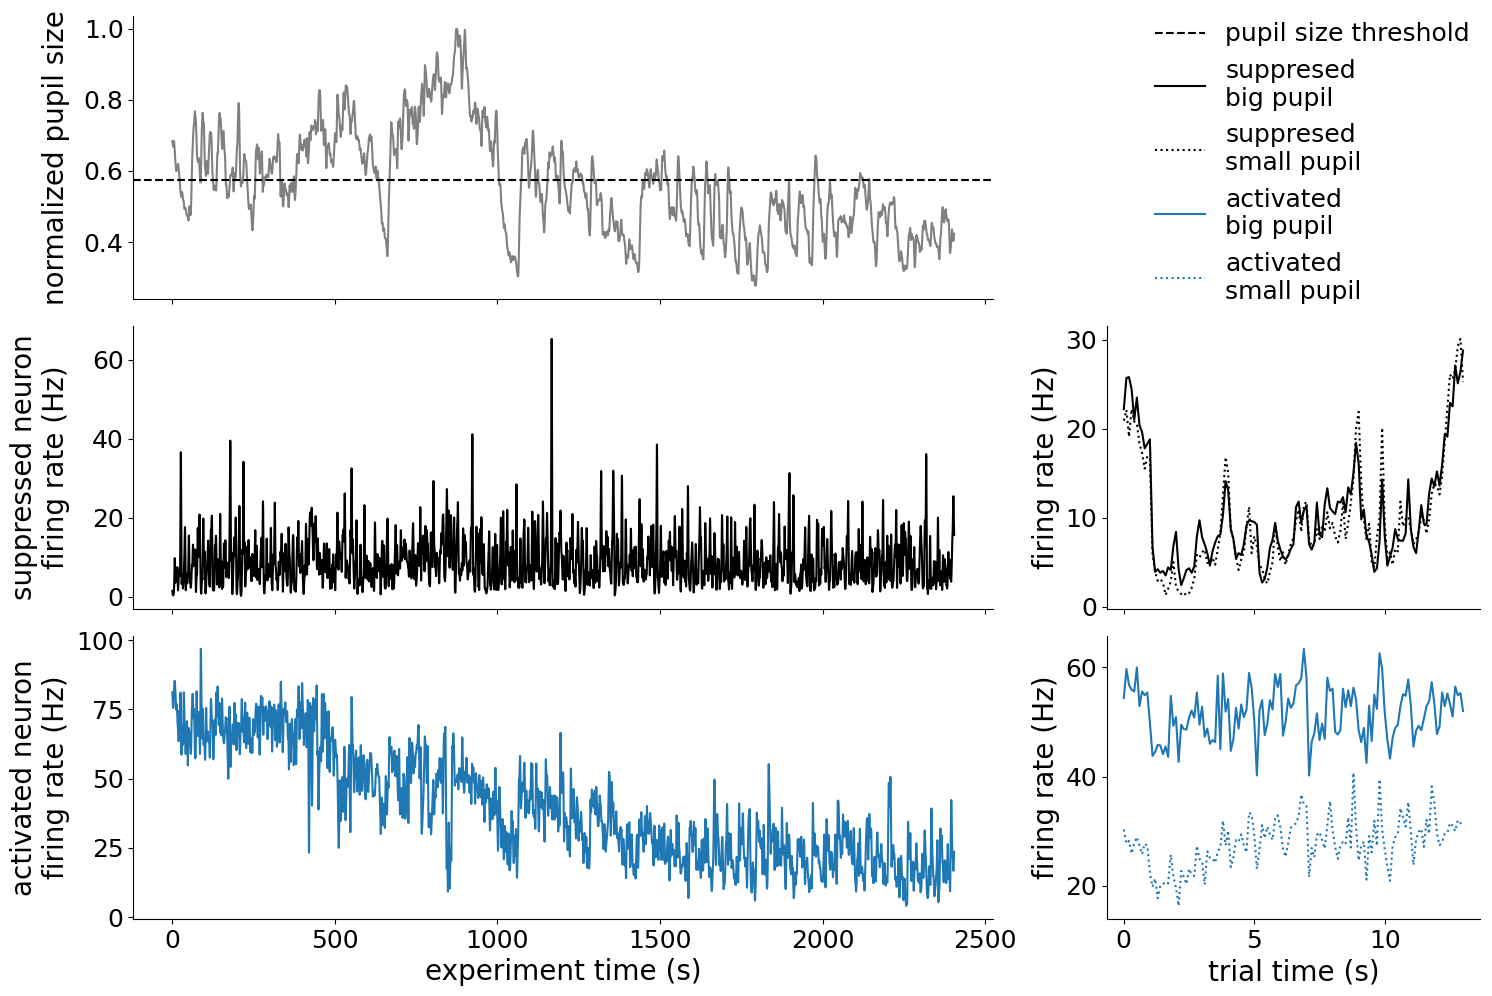

In [21]:
fig = plt.figure(figsize=(15,10))
gs = fig.add_gridspec(3, 3)

ax0 = fig.add_subplot(gs[0,:2])
ax0.plot(rec_time,norm_pup, color='gray')
ax0.set_ylabel('normalized pupil size')
ax0.axhline(pup_threshold, color='black', linestyle='--', label='pupil size threshold')
plt.setp(ax0.get_xticklabels(), visible=False)


ax1 = fig.add_subplot(gs[1,:2], sharex=ax0)
ax1.plot(rec_time,s_resp, color='black')
ax1.set_ylabel('suppressed neuron\nfiring rate (Hz)')
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(gs[2,:2], sharex=ax0)
ax2.plot(rec_time,a_resp, color='C0')
ax2.set_ylabel('activated neuron\nfiring rate (Hz)')
ax2.set_xlabel('experiment time (s)')

ax3 = fig.add_subplot(gs[1,2],)
ax3.plot(ref_time, s_hi_ref, color='black', linestyle='-', label='suppresed\nbig pupil')
ax3.plot(ref_time, s_lo_ref, color='black', linestyle=':', label='suppresed\nsmall pupil')
ax3.set_ylabel('firing rate (Hz)')
plt.setp(ax3.get_xticklabels(), visible=False)


ax4 = fig.add_subplot(gs[2,2], sharex=ax3)
ax4.plot(ref_time, a_hi_ref, color='C0', linestyle='-', label='activated\nbig pupil')
ax4.plot(ref_time, a_lo_ref, color='C0', linestyle=':', label='activated\nsmall pupil')
ax4.set_ylabel('firing rate (Hz)')
ax4.set_xlabel('trial time (s)')

fig.legend()
fig.align_ylabels([ax0, ax1, ax2])
fig.align_ylabels([ax3, ax4])


title = f'pupil example cells'
print(title)
savefig(fig, 'SFN_poster', title, type='png')
savefig(fig, 'SFN_poster', title, type='svg')

# pupil pred

In [22]:
runclass='NAT'
rasterfs=10
runclass='CPN'
rasterfs = 10

sql="select sCellFile.*,gSingleCell.siteid,gSingleCell.phototag from gSingleCell INNER JOIN sCellFile ON gSingleCell.id=sCellFile.singleid" +\
   " INNER JOIN gRunClass on gRunClass.id=sCellFile.runclassid" +\
   f" WHERE gRunClass.name='{runclass}' AND not(isnull(phototag))"
d=nd.pd_query(sql)
d['parmfile']=d['stimpath']+d['stimfile']

print(d.shape)

d=d[['cellid','phototag']].drop_duplicates()
d=d.set_index('cellid')

print(d.shape)


(363, 43)
(363, 1)


In [23]:
if runclass=='CPN':
    #modelnames = ['psth.fs20.pup-ld-st.pup0-epcpn.seq-hrc-psthfr_sdexp2.S_jk.nf20-basic',
    #              'psth.fs20.pup-ld-st.pup-epcpn.seq-hrc-psthfr_sdexp2.S_jk.nf20-basic']
    modelnames = ['psth.fs20.pup-ld-st.pup0-epcpn-hrc-psthfr_sdexp2.S_jk.nf20-basic',
                  'psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_sdexp2.S_jk.nf20-basic']
    modelnames = ['psth.fs20.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic',
                  'psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic']
    batch=331
else:
    batch=322
    modelnames = [f'psth.fs{rasterfs}.pup-ld-st.pup0-hrc-psthfr_stategain.S_jk.nf20-basic',
                  f'psth.fs{rasterfs}.pup-ld-st.pup-hrc-psthfr_stategain.S_jk.nf20-basic',
                ]

In [24]:
dpred = nd.batch_comp(batch=batch,modelnames=modelnames)
dpred = dpred.merge(d['phototag'],how='inner',left_index=True, right_index=True)
dpred['siteid'] = dpred.index
dpred['siteid']=dpred['siteid'].apply(nd.get_siteid)
dpred['diff'] = dpred[modelnames[1]]-dpred[modelnames[0]]

dpred=dpred.merge(waveform_labels[['cellid','wshape']],how='left',left_index=True, right_on='cellid').set_index('cellid')
#dpred['wshape']=dpred['wshape'].fillna("?")
dpred['pw'] = dpred['phototag']+" "+dpred['wshape']

dmean=dpred.groupby('phototag').mean()  # .reset_index()
dcount=dpred.groupby('phototag').count()  # .reset_index()
dcount['n']=dcount[modelnames[0]]
dmean=dmean.merge(dcount['n'],how='inner',left_index=True, right_index=True)
dmean['label'] = [f"{i[0].upper()} n={r.n:.0f} delta={r['diff']:.3f}" for i,r in dmean.iterrows()]
dpred=dpred.merge(dmean[['label']],how='inner',left_on='phototag', right_index=True)

dmean=dpred.groupby(['pw']).mean()  # .reset_index()
dcount=dpred.groupby(['pw']).count()  # .reset_index()
dcount['n']=dcount[modelnames[0]]
dmean=dmean.merge(dcount['n'],how='inner',left_index=True, right_index=True)
dmean['label2'] = [f"{i.upper()} n={r.n:.0f} delta={r['diff']:.3f}" for i,r in dmean.iterrows()]
dpred=dpred.merge(dmean[['label2']],how='inner',left_on=['pw'], right_index=True)

dpred['g']=1
dpred['d']=0

In [25]:
dpred.loc[(dpred['phototag']=='s') & (dpred['siteid']=='TNC016a')].sort_values(by='diff')

,psth.fs20.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,phototag,siteid,diff,wshape,pw,label,label2,g,d
cellid,,,,,,,,,,,
TNC016a-30-2,0.282351,0.281947,s,TNC016a,-0.000404,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-33-1,0.319517,0.319334,s,TNC016a,-0.000183,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-26-1,0.274210,0.274701,s,TNC016a,0.000491,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-43-1,0.276222,0.276862,s,TNC016a,0.000640,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-45-1,0.228268,0.229260,s,TNC016a,0.000992,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-30-1,0.350330,0.351801,s,TNC016a,0.001471,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-29-1,0.225494,0.227431,s,TNC016a,0.001937,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-49-1,0.208638,0.210847,s,TNC016a,0.002209,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0
TNC016a-16-1,0.271580,0.277873,s,TNC016a,0.006294,RS,s RS,S n=167 delta=0.011,S RS n=124 delta=0.011,1,0


In [26]:
for cellid in dpred.index:
    xf,ctx=load_model_xform(cellid=cellid,modelname=modelnames[1],batch=batch,eval_model=False)
    dpred.loc[cellid,'d']=ctx['modelspec'].phi[0]['d'][0,1]
    dpred.loc[cellid,'g']=ctx['modelspec'].phi[0]['g'][0,1]

[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a-01-2/psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-09-16T220425 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a-10-1/psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-09-16T220437 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a-12-1/psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-09-16T220443 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a-20-1/psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-09-16T220458 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/331/TNC013a-22-1/psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr.stategain.S.jk.nf20-basic.2021-09-16T220501 ...
[nems.xforms INFO] Loading xfspec and context from /auto/data/nems_db/results/33

In [27]:
dpred.groupby(['pw']).count()

,psth.fs20.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic,phototag,siteid,diff,wshape,label,label2,g,d
pw,,,,,,,,,,
a NS,20,20,20,20,20,20,20,20,20,20
a RS,12,12,12,12,12,12,12,12,12,12
s NS,23,23,23,23,23,23,23,23,23,23
s RS,124,124,124,124,124,124,124,124,124,124


In [28]:
dpred['diff'] = dpred[modelnames[1]]-dpred[modelnames[0]]
dm = dpred.groupby(['siteid','phototag']).mean()
dmc = dpred.groupby(['siteid','phototag']).count()

dm = dm[['diff']].merge(dmc['label'],how='inner',left_index=True, right_index=True)

In [29]:
dmc

psth.fs20.pup-ld-st.pup0-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic  \
siteid  phototag                                                                        
TNC013a a                                                        10                     
        s                                                        13                     
TNC014a a                                                         1                     
        s                                                        36                     
TNC015a a                                                         5                     
        s                                                        12                     
TNC016a a                                                         5                     
        s                                                        15                     
TNC017a a                                                         2                     
        s                                                        28                     
TNC018a a                                                         9                     
        s                                                        43                     

                  psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic  \
siteid  phototag                                                                       
TNC013a a                                                        10                    
        s                                                        13                    
TNC014a a                                                         1                    
        s                                                        36                    
TNC015a a                                                         5                    
        s                                                        12                    
TNC016a a                                                         5                    
        s                                                        15                    
TNC017a a                                                         2                    
        s                                                        28                    
TNC018a a                                                         9                    
        s                                                        43                    

                  diff  wshape  pw  label  label2   g   d  
siteid  phototag                                           
TNC013a a           10      10  10     10      10  10  10  
        s           13      13  13     13      13  13  13  
TNC014a a            1       1   1      1       1   1   1  
        s           36      36  36     36      36  36  36  
TNC015a a            5       5   5      5       5   5   5  
        s           12      12  12     12      12  12  12  
TNC016a a            5       5   5      5       5   5   5  
        s           15      15  15     15      15  15  15  
TNC017a a            2       2   2      2       2   2   2  
        s           28      28  28     28      28  28  28  
TNC018a a            9       9   9      9       9   9   9  
        s           43      43  43     43      43  43  43

#### Summary plots A: pupil contribution to model prediction. B: pupil-dependent dc and gain. Broken down by A vs. S

Text(0.5, 0.98, 'psth.fs20.pup-ld-st.pup-epcpn-hrc-psthfr_stategain.S_jk.nf20-basic')

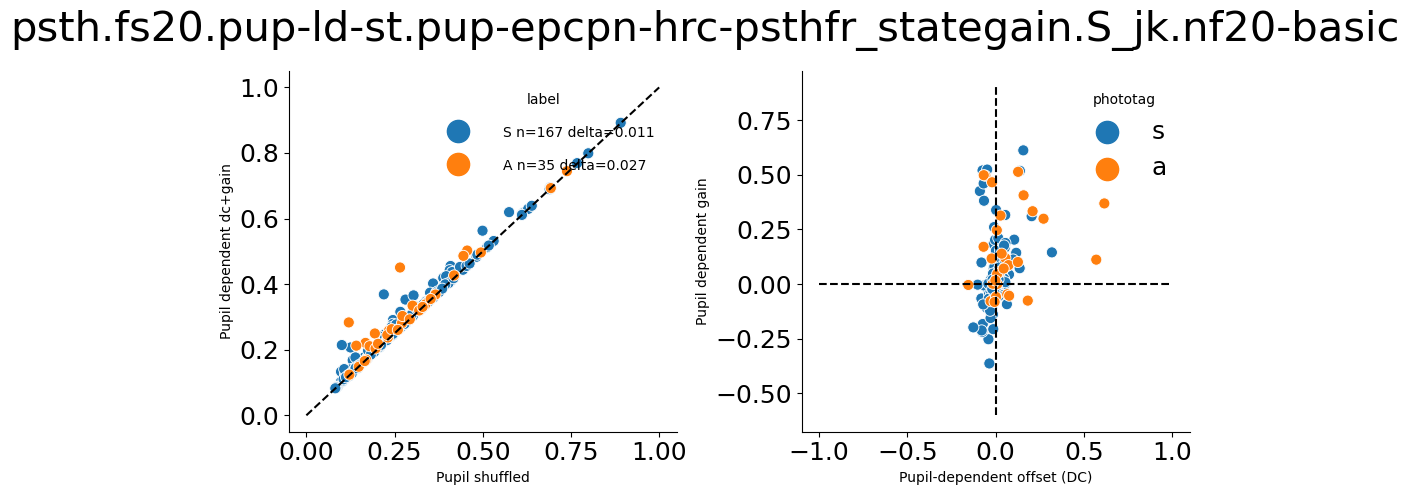

In [30]:
from seaborn import scatterplot, barplot

sa_subset = dpred.loc[(dpred.phototag=='a') | (dpred.phototag=='s')]

f,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].plot([0.0,1],[0.0,1],'k--')
scatterplot(data=sa_subset, x=modelnames[0], y=modelnames[1], hue='label', ax=ax[0]);
plt.setp(ax[0].get_legend().get_texts(), fontsize='10'); #, frameon=False)
ax[0].set_xlabel('Pupil shuffled',fontsize=10)
ax[0].set_ylabel('Pupil dependent dc+gain',fontsize=10)

ax[1].plot([-1,1],[0.0,0],'k--')
ax[1].plot([0.0,0],[-0.6,0.9],'k--')
scatterplot(data=sa_subset, x='d', y='g', hue='phototag', ax=ax[1]);
ax[1].set_xlabel('Pupil-dependent offset (DC)',fontsize=10)
ax[1].set_ylabel('Pupil dependent gain',fontsize=10)

f.suptitle(modelnames[1])


# Presentation ready

pupil effects
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/pupil effects.png
saving figure at /home/mateo/code/context_probe_analysis/reports/figures/SFN_poster/pupil effects.svg


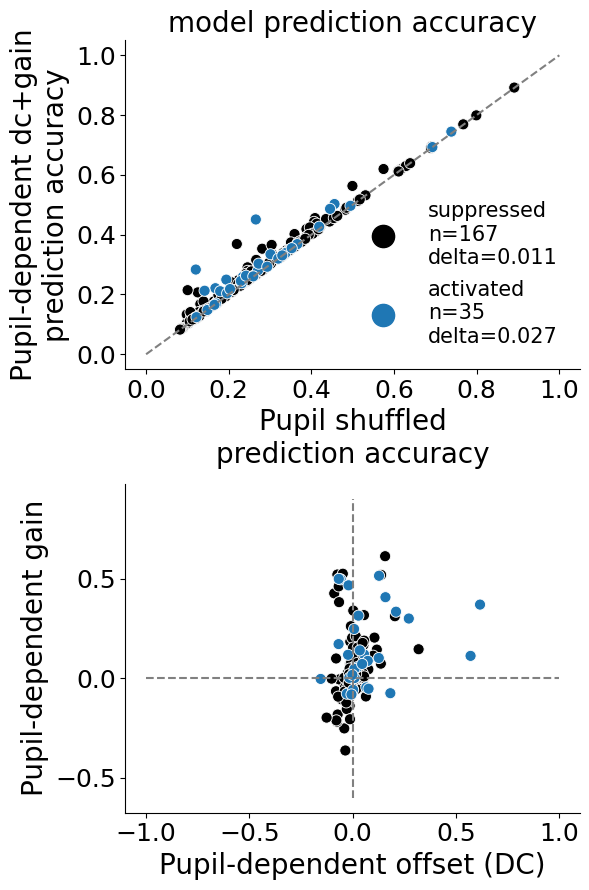

In [45]:
from seaborn import scatterplot, barplot

sa_subset = dpred.loc[(dpred.phototag=='a') | (dpred.phototag=='s')]

fig, ax=plt.subplots(2,1,figsize=(6,9))
scatterplot(data=sa_subset, x=modelnames[0], y=modelnames[1],
            hue='phototag', hue_order=['s','a'], palette=['black', 'C0'], ax=ax[0],
            legend=True);
ax[0].legend(loc='lower right')
L = ax[0].get_legend()
L.set_title('')
L.get_texts()[0].set_text('suppressed\nn=167\ndelta=0.011')
L.get_texts()[0].set_size(15)
L.get_texts()[1].set_text('activated\nn=35\ndelta=0.027')
L.get_texts()[1].set_size(15)

ax[0].plot([0.0,1],[0.0,1], color='gray', linestyle='--')
ax[0].set_title('model prediction accuracy')
ax[0].set_xlabel('Pupil shuffled\nprediction accuracy')
ax[0].set_ylabel('Pupil-dependent dc+gain\nprediction accuracy')

ax[1].plot([-1,1],[0.0,0], color='gray', linestyle='--')
ax[1].plot([0.0,0],[-0.6,0.9], color='gray', linestyle='--')
_ = scatterplot(data=sa_subset, x='d', y='g',
                hue='phototag', hue_order=['s','a'], palette=['black', 'C0'], ax=ax[1],
                legend=False)
# ax[1].get_legend().remove()
ax[1].set_xlabel('Pupil-dependent offset (DC)')
ax[1].set_ylabel('Pupil-dependent gain')


title = f'pupil effects'
print(title)
savefig(fig, 'SFN_poster', title, type='png')
savefig(fig, 'SFN_poster', title, type='svg')

### break down by site.

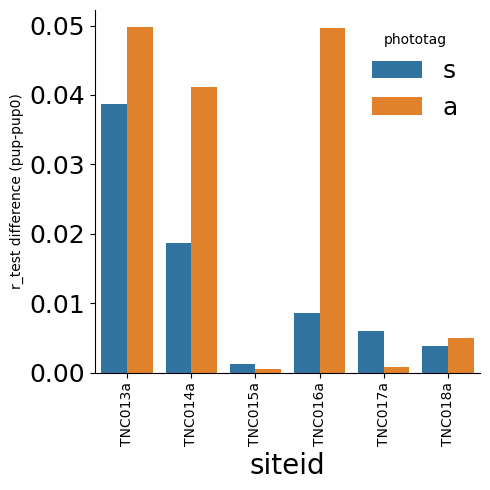

In [32]:
f,ax=plt.subplots(1,1,figsize=(5,5))
barplot(data=dm.reset_index(), x='siteid', y='diff', hue='phototag', ax=ax, hue_order=['s','a'])
plt.setp(ax.get_xticklabels(), fontsize='10', rotation=90); #, frameon=False)
ax.set_ylabel('r_test difference (pup-pup0)',fontsize=10);

In [33]:
dpred.loc[dpred.phototag=='s',['diff','d','g']]

,diff,d,g
cellid,,,
TNC013a-01-2,0.034821,-0.025267,-0.000350
TNC013a-10-1,0.002883,-0.003755,0.000109
TNC013a-12-1,0.003088,-0.011791,0.183123
TNC013a-20-1,0.081789,0.156850,0.612061
TNC013a-22-1,0.013490,0.002717,0.339027
...,...,...,...
TNC015a-22-1,0.000128,0.005313,-0.009555
TNC015a-22-2,-0.000296,-0.005902,-0.041073
TNC015a-30-1,0.000967,-0.019096,-0.022380
